# Funciones de Optimización: RMSprop

## Conjunto de datos

Este es un conjunto de datos de 11.228 noticias de Reuters, etiquetadas en 46 temas.

Esto fue originalmente generado por el análisis y preprocesamiento del clásico conjunto de datos de Reuters-21578, pero el código de preprocesamiento ya no está empaquetado con Keras. 

Cada noticia está codificado como una lista de índices de palabras (números enteros). Para mayor comodidad, las palabras se indexan por la frecuencia general en el conjunto de datos, de modo que, por ejemplo, el número entero "3" codifica la tercera palabra más frecuente en los datos. Esto permite realizar operaciones de filtrado rápido como: "considerar sólo las 10.000 palabras más comunes, pero eliminar las 20 palabras más comunes".

## 1. Cargando el conjunto de datos

In [1]:
from comet_ml import Experiment
experiment = Experiment(
    api_key="HZjgnt81aF3jCfa6GTcp8HNXy",
    project_name="general",
    workspace="josesalazar"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/josesalazar/general/82d2b246f6bc44a6981e7b8a15da4922



In [2]:
from tensorflow.keras.datasets import reuters

2021-11-14 09:59:42.059148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 09:59:42.059177: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

El argumento _num_words_ indica que únicamente tendremos en cuenta las 10.000 palabras más frecuentes del conjunto de datos. Por lo tanto, el resto de palabras que sean poco frecuentes, serán descartadas y no formarán parte de las reseñas con las que entrenaremos y probaremos el algoritmo.

Tanto _train_data_ como _test_data_ se corresponden con una lista de noticias. Cada una de las noticias se corresponde con una lista de números enteros que representan el índice de una palabra. Para conocer que índice tiene cada palabra, podemos llamar al método _get_word_index()_

In [4]:
# Índices de las palabras
word_index = reuters.get_word_index()
word_index

565248/550378 [==============================] - 0s 1us/step


{'mdbl': 10996,
 'fawc': 16260,
 'degussa': 12089,
 'woods': 8803,
 'hanging': 13796,
 'localized': 20672,
 'sation': 20673,
 'chanthaburi': 20675,
 'refunding': 10997,
 'hermann': 8804,
 'passsengers': 20676,
 'stipulate': 20677,
 'heublein': 8352,
 'screaming': 20713,
 'tcby': 16261,
 'four': 185,
 'grains': 1642,
 'broiler': 20680,
 'wooden': 12090,
 'wednesday': 1220,
 'highveld': 13797,
 'duffour': 7593,
 '0053': 20681,
 'elections': 3914,
 '270': 2563,
 '271': 3551,
 '272': 5113,
 '273': 3552,
 '274': 3400,
 'rudman': 7975,
 '276': 3401,
 '277': 3478,
 '278': 3632,
 '279': 4309,
 'dormancy': 9381,
 'errors': 7247,
 'deferred': 3086,
 'sptnd': 20683,
 'cooking': 8805,
 'stratabit': 20684,
 'designing': 16262,
 'metalurgicos': 20685,
 'databank': 13798,
 '300er': 20686,
 'shocks': 20687,
 'nawg': 7972,
 'tnta': 20688,
 'perforations': 20689,
 'affiliates': 2891,
 '27p': 20690,
 'ching': 16263,
 'china': 595,
 'wagyu': 16264,
 'affiliated': 3189,
 'chino': 16265,
 'chinh': 16266,
 '

In [5]:
print("Trainning data:", len(train_data))
print("Testing data:", len(test_data))

Trainning data: 8982
Testing data: 2246


In [6]:
# Primer artículo del conjunto de datos de entrenamiento
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [7]:
reversed_word_index = {v: k for k, v in word_index.items()}
' '.join([reversed_word_index.get(i - 3, '(' + str(i) + ')') for i in train_data[0]])

'(1) (2) (2) said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Las variables _train_labels_ y _test_labels_ se corresponden con una lista de valores que se encuentran en la siguiente lista (*):
```
"reuters":
  ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'],
```
(*) https://github.com/keras-team/keras/issues/12072

In [8]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25])

## Preprocesamiento del conjunto de datos

A pesar de que ya tenemos codificadas las reseñas para que esten representadas por valores numéricos en lugar de por cadenas de texto, existen algunos factores que no permiten que sean conjuntos de datos apropiados para proporcionarle a una red neuronal artifical.

In [9]:
import numpy as np

def vectorize(seqs, dim=10000):
    results = np.zeros((len(seqs), dim))
    for i, seq in enumerate(seqs):
        results[i, seq] = 1.
    return results

Vectorizamos tanto el conjunto de datos de entrenamiento, como el conjunto de datos de pruebas.

In [10]:
# Vectorizamos el conjunto de datos de entrenamiento y el de pruebas
X_train = vectorize(train_data, 10000)
X_test = vectorize(test_data, 10000)

In [11]:
# Cada una de las reseñas se corresponde con un vector formado por 1s y 0s
print("Valores originales:\t", train_data[0][:15])
print("Valores vectorizados:\t", X_train[0][:15])

Valores originales:	 [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16]
Valores vectorizados:	 [0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


In [12]:
# Transformamos las etiquetas de salida en vectores
from tensorflow.keras.utils import to_categorical

Y_train = to_categorical(train_labels)
Y_test = to_categorical(test_labels)

In [13]:
train_labels[0]

3

In [14]:
Y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

## División del conjunto de datos 

In [15]:
from sklearn.model_selection import train_test_split

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)

In [16]:
print("Longitud subconjunto de entrenamiento: ", len(X_train))
print("Longitud subconjunto de validación: ", len(X_val))
print("Longitud subconjunto de pruebas: ", len(X_test))

Longitud subconjunto de entrenamiento:  8982
Longitud subconjunto de validación:  1123
Longitud subconjunto de pruebas:  1123


## Construcción de la red neuronal artificial

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

2021-11-14 10:00:15.435078: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-14 10:00:15.435125: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-14 10:00:15.435176: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2021-11-14 10:00:15.436510: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
from tensorflow.keras import optimizers

opt_func = optimizers.RMSprop()

In [19]:
model.compile(
    optimizer=opt_func,
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision']
)

In [20]:
len(X_train) / 32

280.6875

In [21]:
history = model.fit(
    X_train,
    Y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, Y_val))

2021-11-14 10:00:17.610446: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 359280000 exceeds 10% of free system memory.
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/30


COMET INFO: ignoring tensorflow summary log of metrics because of keras; set `comet_ml.loggers.tensorboard_logger.LOG_METRICS = True` to override


281/281 [==============================] - ETA: 0s - loss: 1.0942 - accuracy: 0.7641 - precision: 0.8822

2021-11-14 10:00:44.702131: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 44920000 exceeds 10% of free system memory.


281/281 [==============================] - 27s 93ms/step - loss: 1.0942 - accuracy: 0.7641 - precision: 0.8822 - val_loss: 0.9387 - val_accuracy: 0.7863 - val_precision: 0.8624
Epoch 2/30
281/281 [==============================] - 26s 91ms/step - loss: 0.4503 - accuracy: 0.9036 - precision: 0.9280 - val_loss: 0.9887 - val_accuracy: 0.7988 - val_precision: 0.8517
Epoch 3/30
281/281 [==============================] - 25s 89ms/step - loss: 0.2995 - accuracy: 0.9399 - precision: 0.9474 - val_loss: 1.2085 - val_accuracy: 0.7934 - val_precision: 0.8330
Epoch 4/30
281/281 [==============================] - 25s 91ms/step - loss: 0.2534 - accuracy: 0.9468 - precision: 0.9508 - val_loss: 1.4434 - val_accuracy: 0.7952 - val_precision: 0.8363
Epoch 5/30
281/281 [==============================] - 26s 91ms/step - loss: 0.2231 - accuracy: 0.9499 - precision: 0.9529 - val_loss: 1.8452 - val_accuracy: 0.7854 - val_precision: 0.8129
Epoch 6/30
281/281 [==============================] - 26s 91ms/step - l

### Predicción con el subconjunto de datos de pruebas

In [22]:
error, accuracy, precision = model.evaluate(X_test, Y_test)

 1/36 [..............................] - ETA: 2s - loss: 8.1980 - accuracy: 0.6562 - precision: 0.6786

2021-11-14 10:14:25.135353: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 44920000 exceeds 10% of free system memory.


36/36 [==============================] - 1s 34ms/step - loss: 7.5683 - accuracy: 0.7756 - precision: 0.8067


In [23]:
print("Error: ", error)
print("Accuracy: ", accuracy)
print("Precision: ", precision)

Error:  7.568279266357422
Accuracy:  0.7756010890007019
Precision:  0.8066732287406921


# Celda final de texto

In [24]:
experiment.end()
#This will allow the experiment to send the log to the website

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/josesalazar/general/82d2b246f6bc44a6981e7b8a15da4922
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [30]                  : (0.764083743095398, 0.958472490310669)
COMET INFO:     batch_accuracy [870]           : (0.03125, 1.0)
COMET INFO:     batch_loss [870]               : (0.0016993613680824637, 3.8162930011749268)
COMET INFO:     batch_precision [870]          : (0.0, 1.0)
COMET INFO:     epoch_duration [30]            : (20.728554104978684, 42.367946576996474)
COMET INFO:     loss [30]                      : (0.12651900947093964, 1.0942474603652954)
COMET INFO:     precision [30]                 : (0.8821756839752197, 0.9599196314811707)
COMET INFO:     val_accuracy [30]              : (0.7622439861297607, 0.79875332117080

Gráficos más importantes

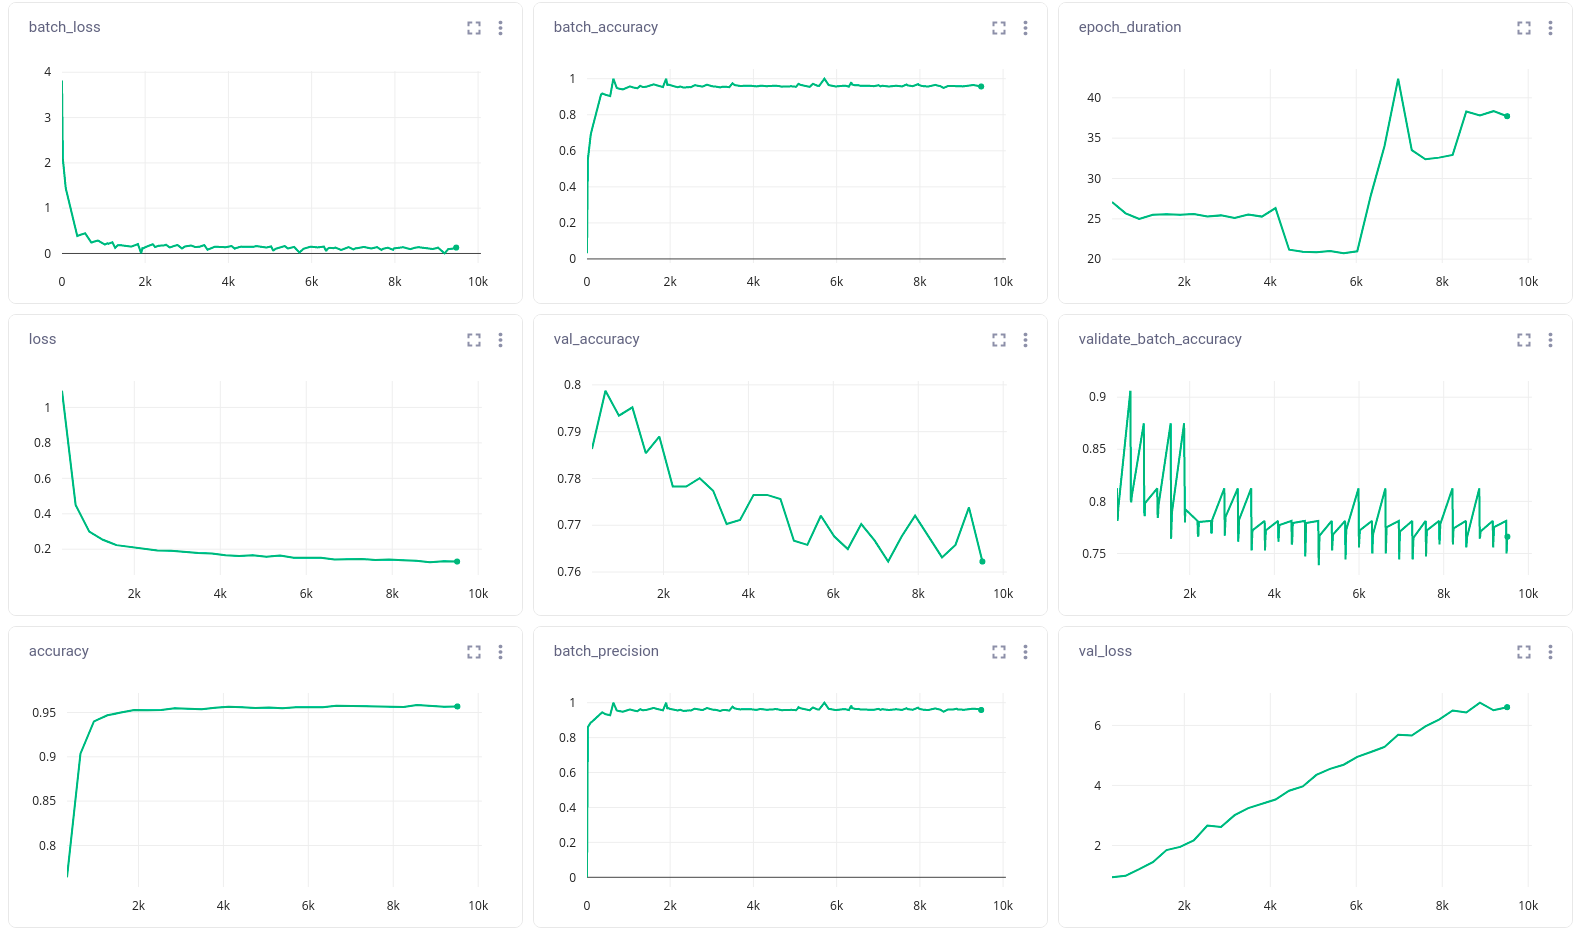

Este gráfico de precisión es esencial y por eso se agrega luego de los otros. 

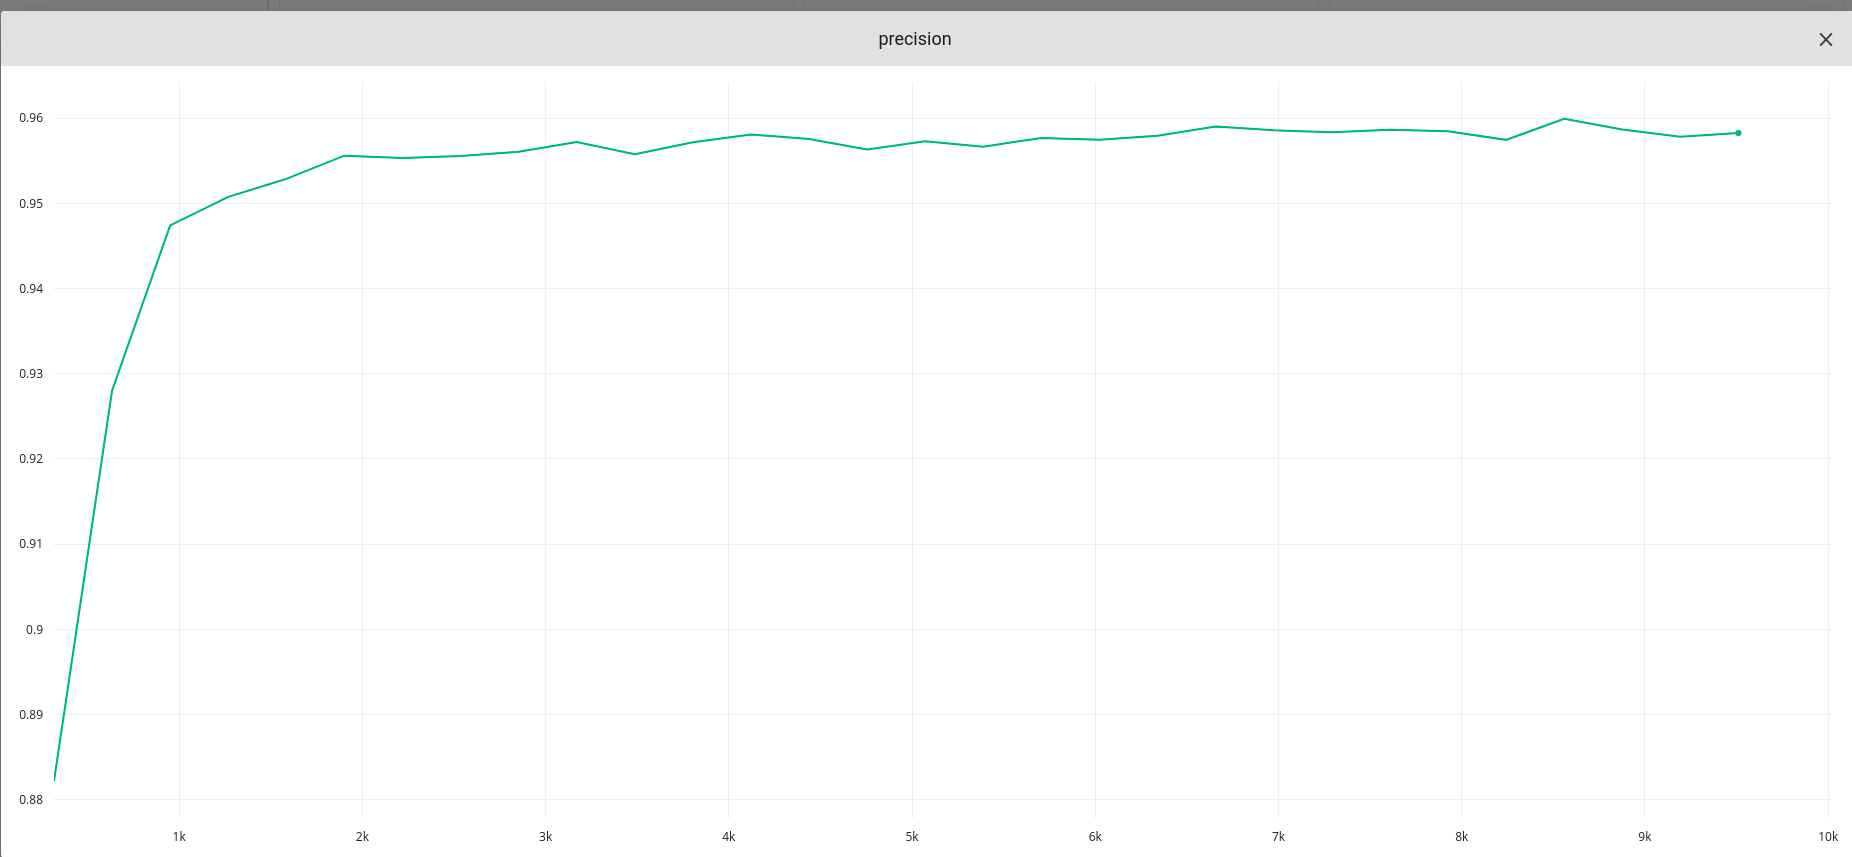

## Conclusiones

Se muestran estos gráficos en conjunto sobre aspectos como value y batches. 

Lo primero es no poner mucha atención a epoch_duration dado que la computadora estaba con varios programas de fondo por lo que la fluctuación no necesariamente es por los datos. 

Ahora, podemos mencionar que precision y accuracy tienen un crecimiento muy rápido, lo cual es característico de RMSprop por su forma de calcular wt ya que divide el learning rate por el gradiente por lo que se encuentra el punto óptimo con mayor velocidad. 

Por esto mismo, el gráfico de loss muestra como desde el inicio este se desploma para alcanzar una disminución lenta pero constante. Si vemos este gráfico y accuracy/precision podemos observar que son simétricos, y esto permite denotar una correcta calificación y comportamiento del algoritmo. 

Sin embargo, al analizar el validation accuracy vemos que este va decayendo poco a poco y no se recupera, pero el accuracy normal sigue el patrón deseado. Esto indica un clarísimo over-fitting

El otro valor que denota el overfitting es el val_loss que si vemos solo sube por lo que no se consigue el objetivo que es estar al mínimo.


Ahora, sobre la herramienta comet en sí, podemos decir que muestra de una manera bastante cómoda estos gráficos. Un detalle que podría mejorar es ordenar los gráficos de batch, validation y demás en orden para mayor comprensión. Otro punto es que los gráficos aunque se ven del mismo color, existe una opción para modificar esto, por lo que se puede conseguir lo anteriormente mencionado de otra forma. 

La forma  de llamar a comet es generando un experiment y una vez que terminamos de procesar lo deseado se invoca experiment.end() en caso de que estemos con un cuaderno de tipo local. Esto le permite a comet saber cuando procesar los datos y reducir cantidad de peticiones y envíos. 